## Compare PCA weights spatially

In [3]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn import metrics
from sklearn import decomposition
from sklearn.preprocessing import normalize
from scipy.stats import ks_2samp
import scipy.io as sio
import os
import importlib
import rutils
from pyaldata import *
from rutils import *
from tqdm import tqdm

'''
Plotting aesthetics
'''
sns.set_style('white')
sns.set_context('notebook', font_scale=1.35)

#sns.light_palette(color='electric blue', input='xkcd')
cmap = sns.light_palette(color='electric blue', input='xkcd', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)

cs = ['#319FF1', '#0B3856', '#C32D13', '#EBE12E', '#3D7E43', '#2D2F39', '#4D7399', '#CDBCA5']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)

'''
Magic commands
'''

%load_ext autoreload
%autoreload 5
%config InlineBackend.figure_format = "retina"

[xkcd colors](https://xkcd.com/color/rgb/)

## 0 Load data and electrode maps

In [4]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = mat2dataframe(path+fname, shift_idx_fields=True)

Read in the electrode map for both array

In [5]:
df_m1_arr  = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left M1 SN 6250-001474.cmp')
df_pmd_arr = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left PMd SN 6251-001469.cmp')

In [6]:
m1_elecmap  = localize_elecs(df_m1_arr, elecs=range(1,97))
pmd_elecmap = localize_elecs(df_pmd_arr, elecs=range(1,97))

## 1 Preprocess 

### 1.1 Combine time bins

In [7]:
td = combine_time_bins(df, n_bins=3)

### 1.2 Remove low firing neurons

In [8]:
td = remove_low_firing_neurons(td, signal='M1_spikes', threshold=5)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=5)

### 1.3 Transform signals

In [9]:
td = transform_signal(td, signal='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signal='PMd_spikes', transformations='sqrt')

### 1.4 Merge signals

In [10]:
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

### 1.5 Compute firing rates from spike trains

Add firing rates for `M1_spikes`, `PMd_spikes` and `both_spikes`

In [11]:
# works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

In [12]:
td.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,Chewie,10-06-2016,CO,-2.356194,1,R,0.03,VR,-0.52,BL,...,"[[25.292273710326047, 23.948816622289783], [26...","[[0.3854857746577438, -0.18448026169727955], [...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[10.371933240023875, 15.773752026832693, 12.3...","[[8.902097383481504, 8.635500399091704, 6.2947...","[[10.371933240023875, 15.773752026832693, 12.3..."
1,Chewie,10-06-2016,CO,1.570796,2,R,0.03,VR,-0.52,BL,...,"[[33.67115720999763, 79.08430607100303], [23.7...","[[0.1778157378731141, 0.12542049016429982], [0...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.414213562373...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[11.264847879857852, 14.03731918590052, 8.031...","[[5.401818786808815, 14.407176539761242, 13.14...","[[11.264847879857852, 14.03731918590052, 8.031..."
2,Chewie,10-06-2016,CO,0.785398,3,R,0.03,VR,-0.52,BL,...,"[[1.6623846773446733, -20.151668914256682], [4...","[[0.2833417683274762, -0.1285513884878812], [0...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.4142135623730951, 1.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[10.371933240023875, 16.66666666666667, 11.84...","[[16.66666666666667, 10.949669788579067, 7.742...","[[10.371933240023875, 16.66666666666667, 11.84..."
3,Chewie,10-06-2016,CO,3.141593,4,R,0.03,VR,-0.52,BL,...,"[[-10.229040288523265, -22.654816986306813], [...","[[0.08675043530985374, 0.03658922221440793], [...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8929146398339769, 8.635500399091704, 10.26...","[[0.8929146398339769, 7.742585759257727, 5.401...","[[0.8929146398339769, 8.635500399091704, 10.26..."
4,Chewie,10-06-2016,CO,-1.570796,5,R,0.03,VR,-0.52,BL,...,"[[55.86100520057167, -6.586410543949703], [45....","[[0.2054977133197953, -0.12485484173352068], [...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[8.031166267574964, 8.924080907408943, 13.144...","[[15.773752026832693, 16.66666666666667, 0.892...","[[8.031166267574964, 8.924080907408943, 13.144..."


### 1.6 Select data from Baseline epoch

Select only those rows from the baseline epoch `'BL'`

In [13]:
td = td.loc[df['epoch'] == 'BL']

In [14]:
td.shape

(217, 28)

## 2 Dimensionality reduction with Sparse PCA

The optimization problem solved is a PCA problem (dictionary learning) with an L1 penalty on the components

\begin{align}
    (U^{*}, V^{*}) = \underset{\text{U, V}}{\text{arg min}} \frac{1}{2} \| X - UV \|_2^2 + \alpha \| V \|_1
\end{align}


subject to $\| U_k \|_2 = 1$ for all $0 \leq k < n_{components}$

---

> [Sparse PCA with sklearn](https://github.com/scikit-learn/scikit-learn/issues/13127) and [potential issue](https://github.com/scikit-learn/scikit-learn/issues/11512)

> [Original SPCA paper](https://web.stanford.edu/~hastie/Papers/spc_jcgs.pdf)

- Sparsity is a useful perspective to promote parsimonious models that avoid overfitting and remain interpretable because they have the minimal number of terms required to explain the data.
- This is related to Occam’s razor, which states that the simplest explanation is generally the correct one.


---

**To do list** 

- Problem: this variant of spca is different than the one in the original paper. Run sparse pca with [R and/or implement this spca variant in Python](https://github.com/erichson/spca), then compare the results.
- Find more ways to express the similarity between vectors
- Experiment with different values of $\alpha$ and get percent of sparse elements
- Plot densities for all pcs
- How to quantify the performance of SPCA? Decode hand velocities with the reduced pca

---

### 2.1 Run sparse pca


In [15]:
alph = 1 # choose penalty strength

X = np.concatenate(td['both_rates'].values, axis=0)
spca = decomposition.MiniBatchSparsePCA(n_components=X.shape[1], alpha=alph, verbose=4, normalize_components=True) # have to set normalise components 
spca.fit(X);

Iteration   0 (elapsed time:   2s,  0.0mn)
Iteration  25 (elapsed time:  60s,  1.0mn)
Iteration  50 (elapsed time:  109s,  1.8mn)
Iteration  75 (elapsed time:  157s,  2.6mn)
Learning code... done (total time:  209s,  3.5mn)


#### Compute explained variance

- SPCA does not explicitly impose the uncorrelated components condition either.
- Page 273 in (Zou, Hastie and Tibshirani, 2006) explains how we can compute the variance.
- Normally the total variance explained by $\hat{\mathbf{{Z}}}$ is $\text{tr}[\hat{\mathbf{{Z}}}^T \hat{\mathbf{{Z}}}]$
- For SPCA we need a new formula to compute the total variance explained by $\hat{\mathbf{{Z}}}$ which takes into account the correlations within the matrix.

Let $\hat{\mathbf{{Z}}}$ be the modified PCs, the explained variance is
\begin{align}
    \sum_{j=1}^k = \mathbf{R}^2_{jj}
\end{align}

In [16]:
Z = spca.transform(X)
spcs = spca.components_

Do a QR factorisation on the transformed principal components.

$Q$ is an orthonormal matrix, $R$ is an upper triangular matrix

In [17]:
Q,R = np.linalg.qr(Z)

Compute the variances

In [18]:
exp_var = np.array([round((R[i][i]**2),3) for i in range(R.shape[0])])
exp_var_ratio = exp_var.cumsum()/max(exp_var.cumsum()) # normalize
exp_var = exp_var/max(exp_var.cumsum()) # normalize

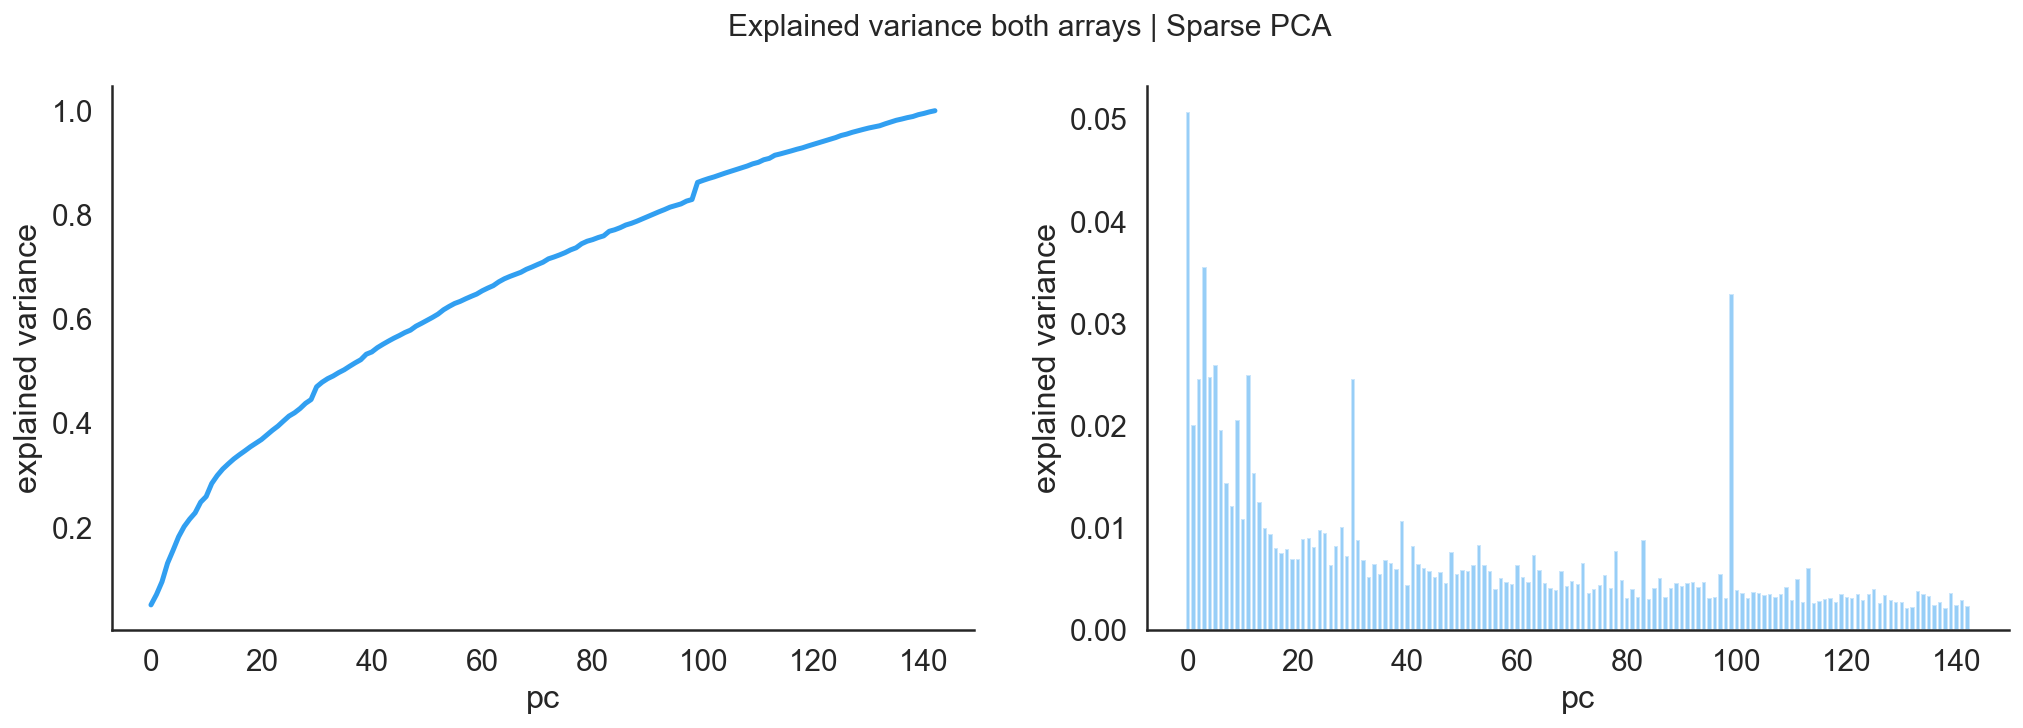

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))

fig.suptitle(f'Explained variance both arrays | Sparse PCA', fontsize=15)
ax1.plot(exp_var_ratio, lw=2.5)
ax1.set_xlabel('pc')
ax1.set_ylabel('explained variance')

ax2.bar(range(0, len(exp_var)), exp_var)
ax2.set_xlabel('pc')
ax2.set_ylabel('explained variance')
sns.despine();

### 2.2 Display the weights

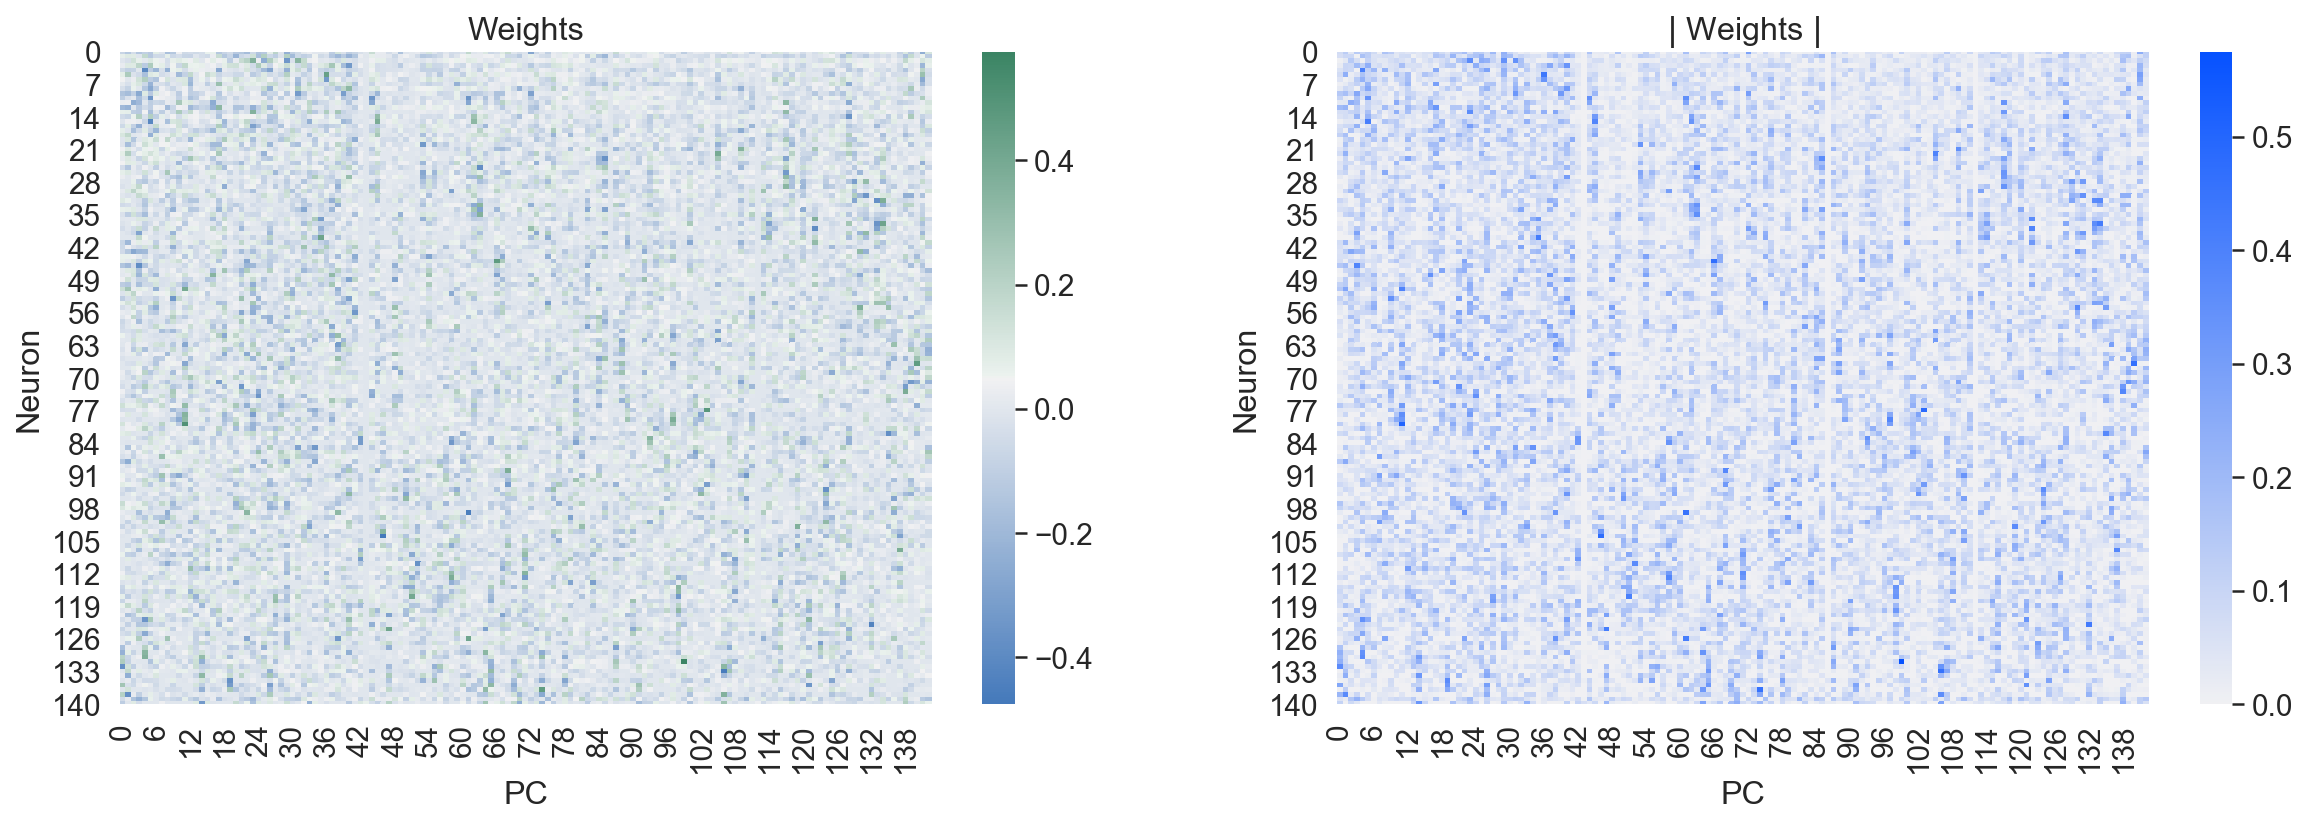

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(spcs, cmap=div_cmap, ax=ax1)
ax1.set_title('Weights')
ax1.set_xlabel('PC')
ax1.set_ylabel('Neuron')

sns.heatmap(abs(spcs), cmap=cmap, ax=ax2)
ax2.set_title(r'$|$ Weights $|$')
ax2.set_xlabel('PC')
ax2.set_ylabel('Neuron');

### 2.3 Measure similarity between pcs

### Correlation matrix 

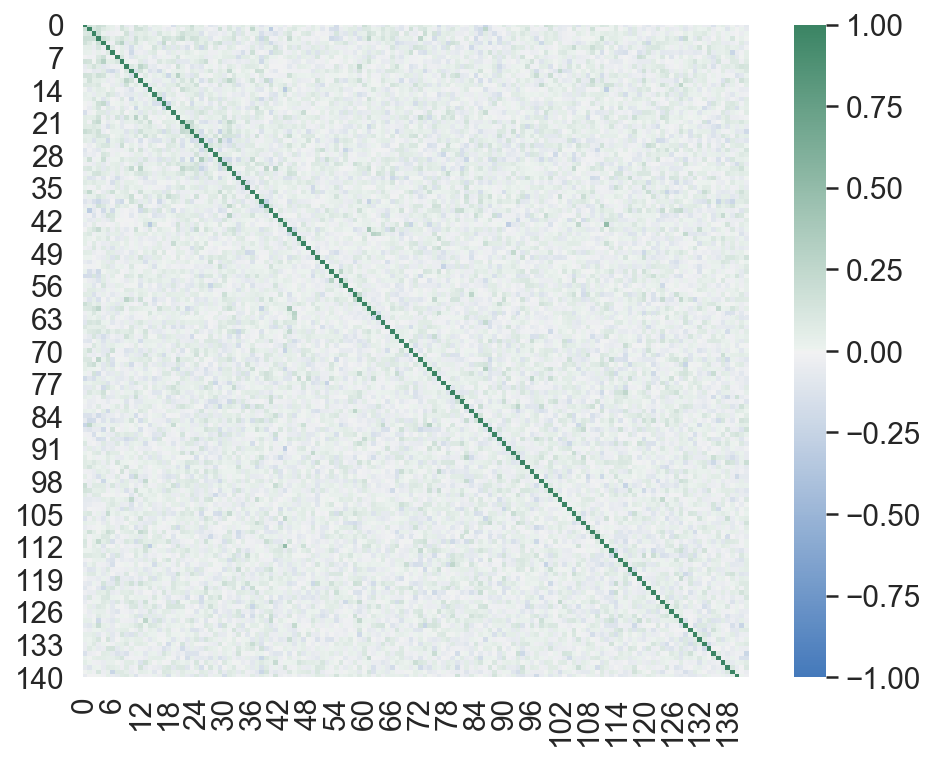

In [21]:
spcs_corr = pd.DataFrame(spcs).corr() # NOTE: 2 extra pixs?????

fig, ax = plt.subplots(1, figsize=(8, 6))
sns.heatmap(spcs_corr, 
           vmin=-1, vmax=1, center=0,
           cmap=div_cmap,
           square=True);

### Cosine similarity

In [22]:
spcs

array([[-0.07414912, -0.12948973, -0.03796306, ..., -0.01291809,
        -0.24197148,  0.11592138],
       [ 0.06654026,  0.09379011,  0.08772244, ..., -0.01374221,
         0.0564697 , -0.11263609],
       [-0.00453559, -0.03211285,  0.13946825, ...,  0.04098297,
         0.11968657,  0.07917771],
       ...,
       [-0.10967175,  0.        ,  0.08685708, ...,  0.        ,
         0.11691377,  0.06028014],
       [-0.05351744,  0.        ,  0.07355239, ...,  0.0032438 ,
         0.04354051,  0.12933511],
       [ 0.        ,  0.04593749,  0.        , ...,  0.        ,
         0.0427263 ,  0.        ]])

### Measure sparseness

\begin{align}
    \text{sparsity}(A) = 1 - \frac{\text{non zero elements(A)}}{\text{total elements(A)}}
\end{align}

In [23]:
sparseness = lambda x: 1 - np.count_nonzero(x)/x.size

### 2.4 Display the weight difference distribution

In [24]:
'''
Pick the principal components for weight comparison
'''
pc_num = 0

In [25]:
# compare weights
df = compare_pc_weights(m1_arr=m1_elecmap, m1_ug=td['M1_unit_guide'][0], pmd_arr=pmd_elecmap, pmd_ug=td['PMd_unit_guide'][0], w=spcs[:, pc_num] )
df_m1_other  = df.loc[df['array'].isin(['M1', np.nan])]
df_pmd_other = df.loc[df['array'].isin(['PMd', np.nan])]
df_same_arr = df.loc[df['group'] == 'same array']

m1_cats = df_same_arr.loc[df['array']=='M1']
pmd_cats = df_same_arr.loc[df['array']=='PMd']

NameError: name 'dfs' is not defined

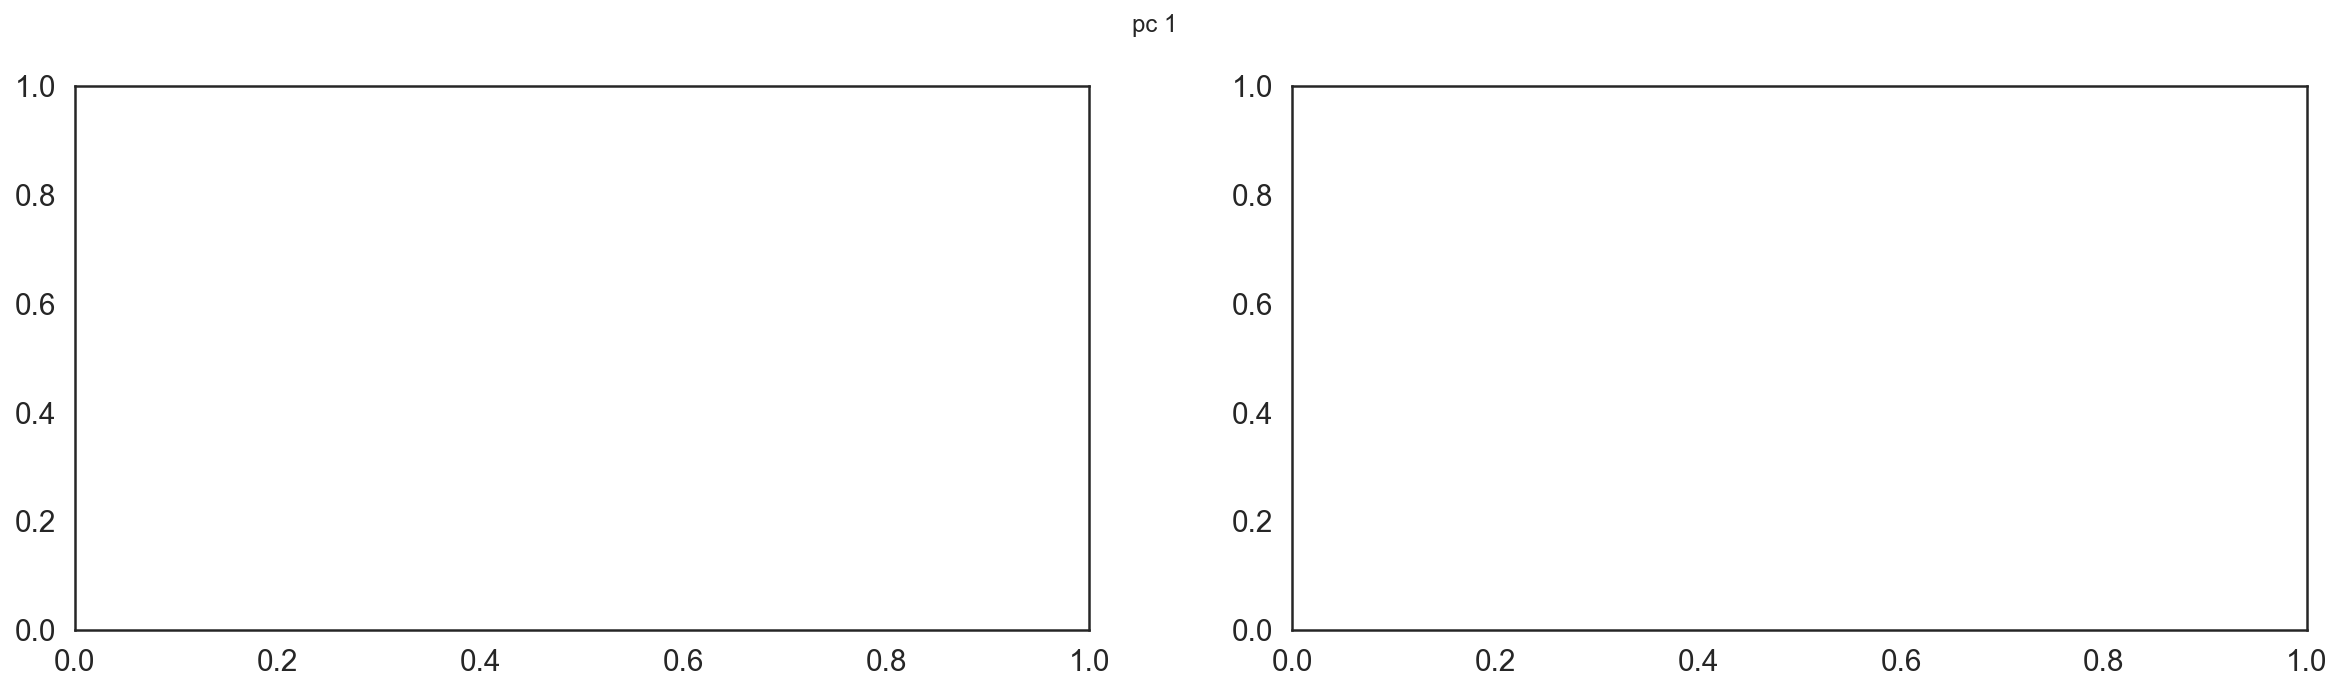

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'pc {pc_num + 1}')
sns.histplot(dfs, x='w_diff', hue='array', bins=binz, stat='count', multiple='stack', ax=ax1)
ax1.set_title('Comparison PC weights within arrays')
ax1.set_xlabel('Difference in weight to first PC')

sns.histplot(dfs, x='w_diff', hue='group', bins=binz, stat='count', multiple='stack', ax=ax2)
ax2.set_title('Comparison PC weights for both arrays combined')
ax2.set_xlabel('Difference in weight to first PC')
sns.despine()

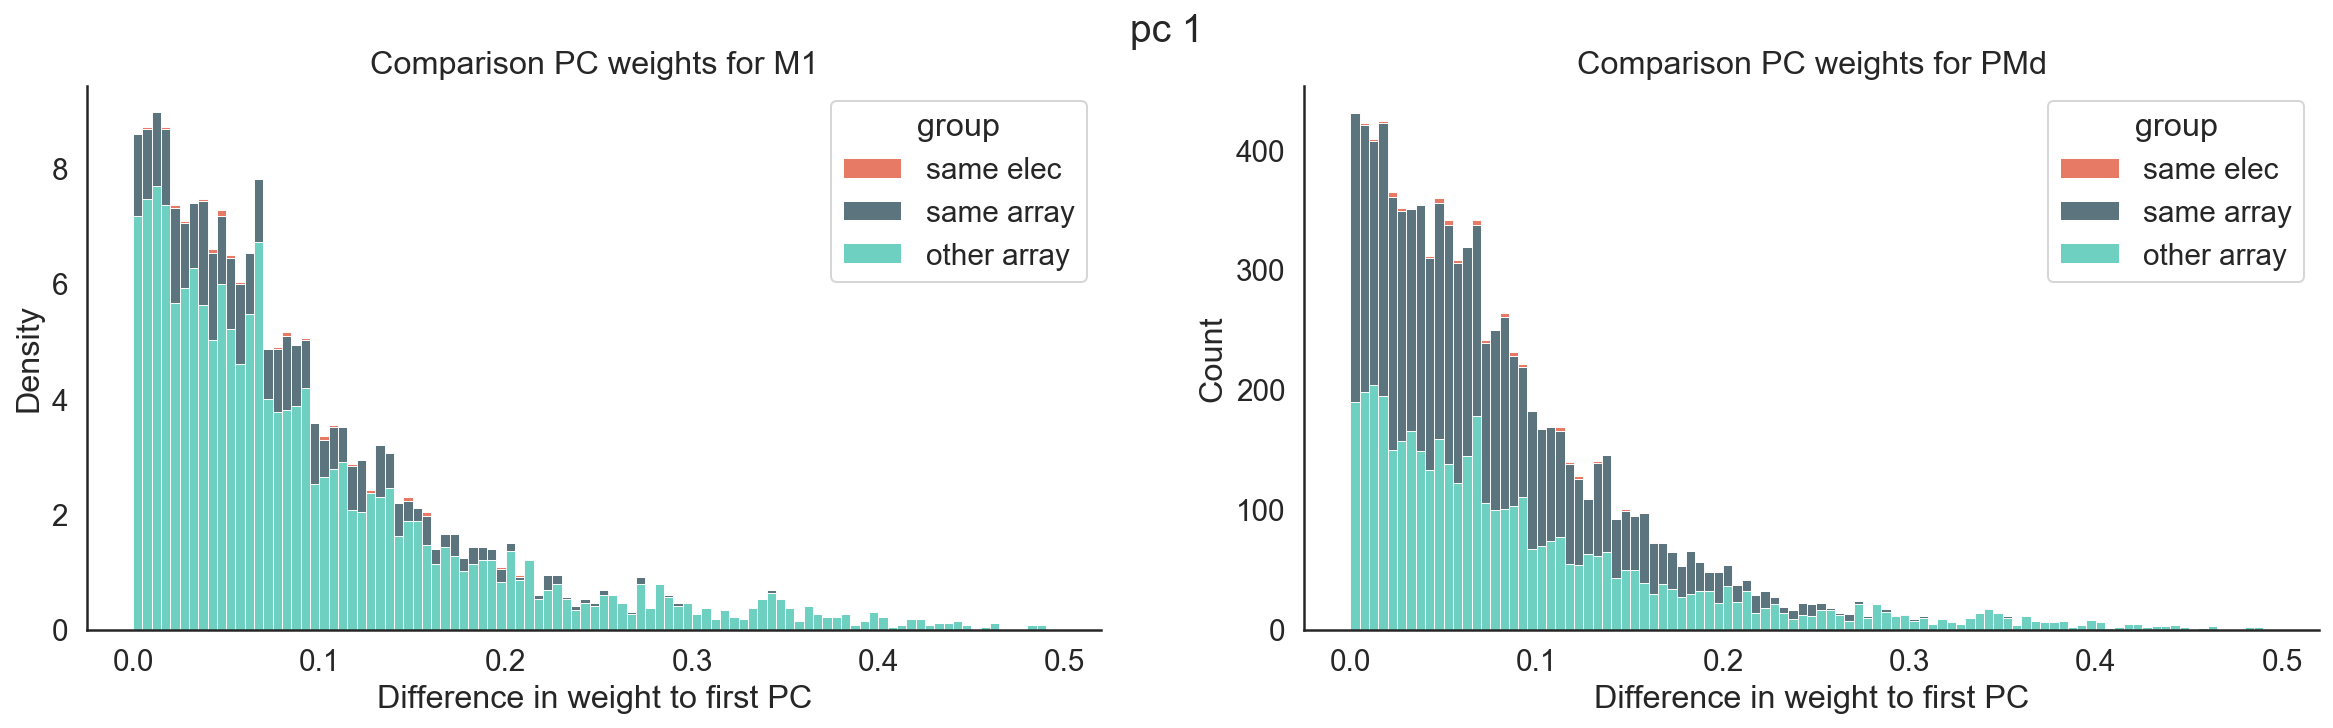

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'pc {pc_num + 1}')

sns.histplot(dfs_m1_other, x='w_diff', hue='group', bins=binz, stat='density', multiple='stack', ax=ax1)
ax1.set_title('Comparison PC weights for M1')
ax1.set_xlabel('Difference in weight to first PC')

sns.histplot(dfs_pmd_other, x='w_diff', hue='group', bins=binz, stat='count', multiple='stack', ax=ax2)
ax2.set_title('Comparison PC weights for PMd')
ax2.set_xlabel('Difference in weight to first PC')
sns.despine()

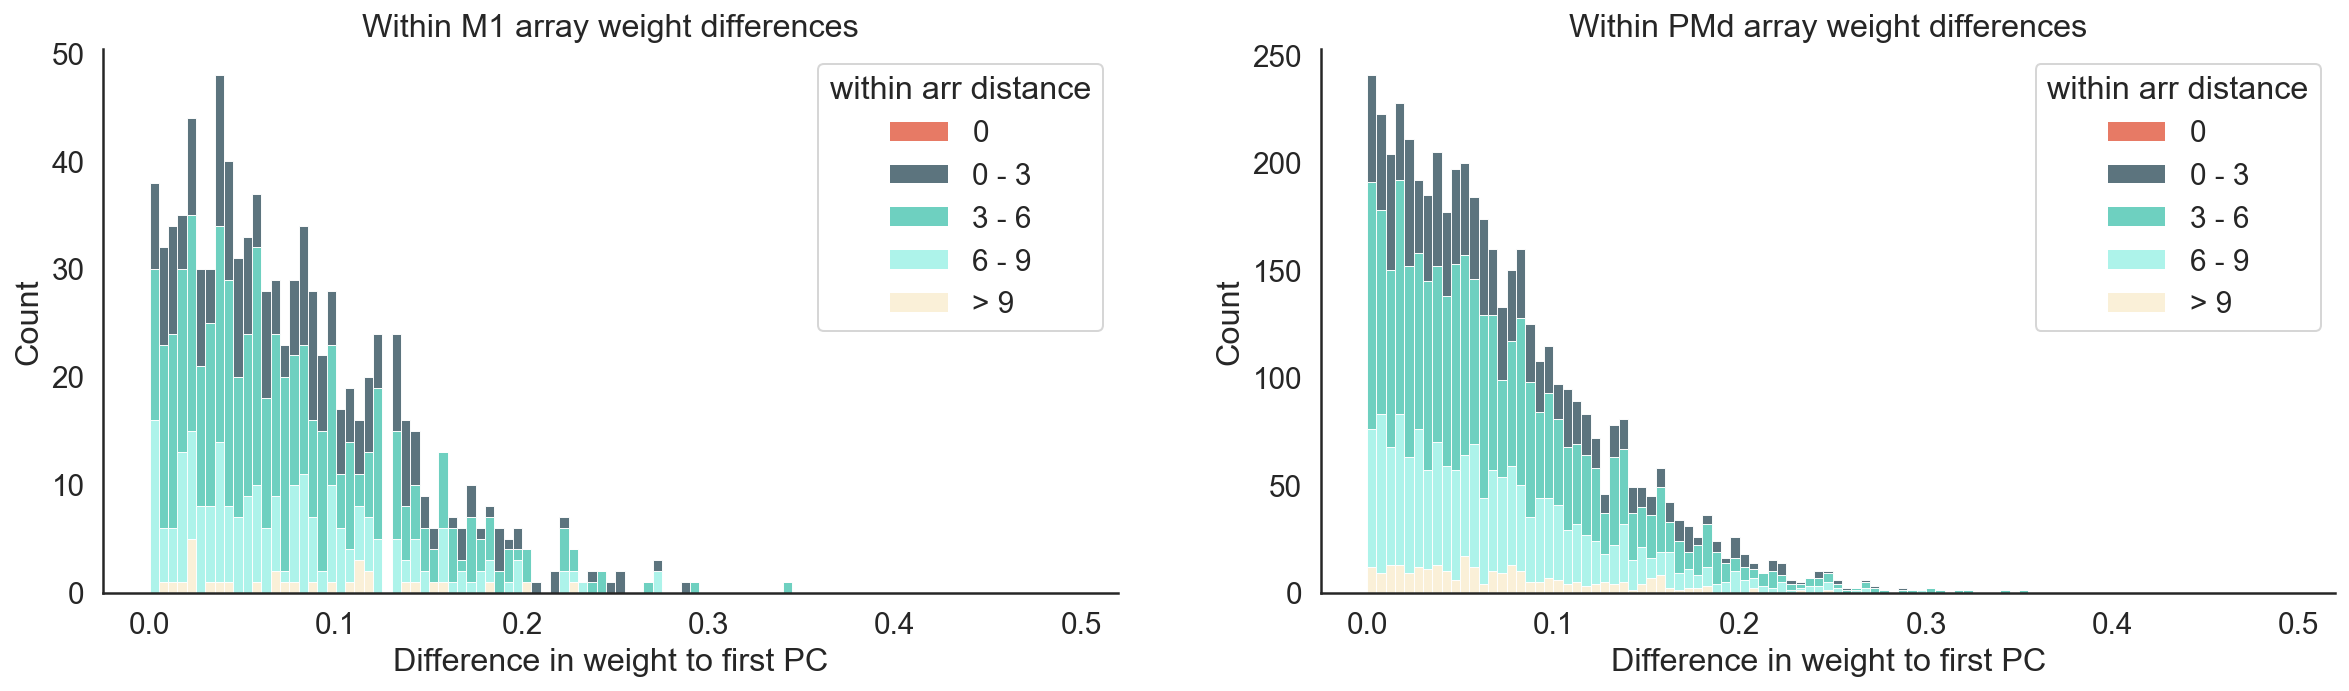

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(m1_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax1, multiple='stack')
ax1.set_title('Within M1 array weight differences')
ax1.set_xlabel('Difference in weight to first PC')

sns.histplot(pmd_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax2, multiple='stack')
ax2.set_title('Within PMd array weight differences')
ax2.set_xlabel('Difference in weight to first PC')
sns.despine()

In [46]:
dfs_m1_other.loc[dfs_m1_other['group'] == 'same array']

,distance,w_diff,array,group,within arr distance
1,5.099020,0.062326,M1,same array,3 - 6
2,5.099020,0.098246,M1,same array,3 - 6
3,1.414214,0.060824,M1,same array,0 - 3
4,1.414214,0.105351,M1,same array,0 - 3
5,1.414214,0.043216,M1,same array,0 - 3
...,...,...,...,...,...
938,1.000000,0.080667,M1,same array,0 - 3
939,4.000000,0.015808,M1,same array,3 - 6
942,3.000000,0.116083,M1,same array,0 - 3
944,3.000000,0.043320,M1,same array,0 - 3


In [42]:
dfs_m1_other.loc[dfs_m1_other['group'] == 'same elec']['distance']

0      0.0
85     0.0
166    0.0
167    0.0
205    0.0
385    0.0
450    0.0
451    0.0
481    0.0
540    0.0
595    0.0
693    0.0
775    0.0
776    0.0
777    0.0
793    0.0
794    0.0
810    0.0
841    0.0
868    0.0
891    0.0
892    0.0
901    0.0
931    0.0
940    0.0
941    0.0
943    0.0
Name: distance, dtype: float64

In [43]:
dfs_m1_other.loc[dfs_m1_other['group'] == 'same elec']['w_diff'].values

array([0.20889284, 0.03591976, 0.0445276 , 0.10403993, 0.14856753,
       0.05770338, 0.08379626, 0.10231055, 0.01851428, 0.04129927,
       0.02333878, 0.04844429, 0.04938324, 0.08020315, 0.07710461,
       0.12958639, 0.02772136, 0.15730776, 0.11815159, 0.00991491,
       0.19745985, 0.14820656, 0.04925329, 0.09019494, 0.15940272,
       0.05122404, 0.10817868])

(array([4., 6., 2., 3., 4., 1., 3., 2., 0., 2.]),
 array([0.00991491, 0.02981271, 0.0497105 , 0.06960829, 0.08950608,
        0.10940388, 0.12930167, 0.14919946, 0.16909725, 0.18899505,
        0.20889284]),
 <a list of 10 Patch objects>)

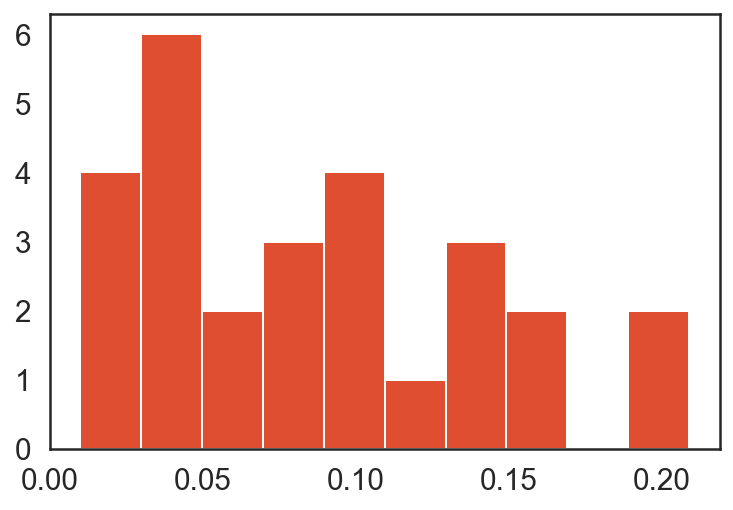

In [44]:
plt.hist(dfs_m1_other.loc[dfs_m1_other['group'] == 'same elec']['w_diff'].values

In [44]:
dfs_pmd_other.loc[dfs_pmd_other['group'] == 'same elec']['distance']

946     0.0
1141    0.0
1332    0.0
1333    0.0
1426    0.0
       ... 
5719    0.0
5742    0.0
5743    0.0
5752    0.0
5791    0.0
Name: distance, Length: 63, dtype: float64

In [2]:
def generate_weight_distrib(pc_num):

    # compare weights of pc number K
    df = compare_pc_weights(m1_arr=m1_elecmap, m1_ug=td['M1_unit_guide'][0], pmd_arr=pmd_elecmap, pmd_ug=td['PMd_unit_guide'][0], w=spcs[:, pc_num])
    
    df_m1  = df.loc[df['array'].isin(['M1', np.nan])]
    df_pmd = df.loc[df['array'].isin(['PMd', np.nan])]
    df_same_arr = df.loc[df['group'] == 'same array']
    # make within categories
    m1_cats = df_same_arr.loc[df['array']=='M1']
    pmd_cats = df_same_arr.loc[df['array']=='PMd']

    
    # Generate 2 x 2 plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f'pc number {pc_num + 1}', fontsize=18)
    
    # global settings
    binz = np.arange(0, 0.5, 0.01)
    xbar = [str(bin) for bin in binz]
    intvals = np.append(binz, np.inf)
    
    # M1
    se = df_m1.loc[df_m1['group'] == 'same elec']['w_diff'].values
    sa = df_m1.loc[df_m1['group'] == 'same array']['w_diff'].values
    oa = df_m1.loc[df_m1['group'] == 'other array']['w_diff'].values

    ax1.set_title('pc weight distribution M1, sorted by group')
    oa_bins = [np.sum((oa >= intvals[i]) & (oa < intvals[i + 1])) for i in range(len(binz))]
    oa_bins = oa_bins / max(oa_bins)
    ax1.bar(x=xbar, height=oa_bins, label='Other array')

    sa_bins = [np.sum((sa >= intvals[i]) & (sa < intvals[i + 1])) for i in range(len(binz))]
    sa_bins = sa_bins / max(sa_bins)
    ax1.bar(x=xbar, height=sa_bins, label='Same array', alpha=.7)

    se_bins = [np.sum((se >= intvals[i]) & (se < intvals[i + 1])) for i in range(len(binz))]
    se_bins = se_bins / max(se_bins)
    ax1.bar(x=xbar, height=se_bins,  label='Same electrode', alpha=.7)
    ax1.set_xlabel(r'$w_{diff}$')
    ax1.set_xticks([str(i / 10) for i in range(0, 6)])
    
    # PMD
    se = df_pmd.loc[df_pmd['group'] == 'same elec']['w_diff'].values
    sa = df_pmd.loc[df_pmd['group'] == 'same array']['w_diff'].values
    oa = df_pmd.loc[df_pmd['group'] == 'other array']['w_diff'].values
    
    ax2.set_title('pc weight distribution PMd, sorted by group')
    oa_bins = [np.sum((oa >= intvals[i]) & (oa < intvals[i + 1])) for i in range(len(binz))]
    oa_bins = oa_bins / max(oa_bins)
    ax2.bar(x=xbar, height=oa_bins, label='Other array')

    sa_bins = [np.sum((sa >= intvals[i]) & (sa < intvals[i + 1])) for i in range(len(binz))]
    sa_bins = sa_bins / max(sa_bins)
    ax2.bar(x=xbar, height=sa_bins, label='Same array', alpha=.7)

    se_bins = [np.sum((se >= intvals[i]) & (se < intvals[i + 1])) for i in range(len(binz))]
    se_bins = se_bins / max(se_bins)
    ax2.bar(x=xbar, height=se_bins,  label='Same electrode', alpha=.7)
    ax2.set_xlabel(r'$w_{diff}$')
    ax2.set_xticks([str(i / 10) for i in range(0, 6)])
    ax2.legend()
    sns.despine()
    
    # within array plots with seaborn (not scaled)
    sns.histplot(m1_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax3, multiple='stack')
    ax3.set_title('Within M1 array weight differences')
    ax3.set_xlabel(r'$w_{diff}$')

    sns.histplot(pmd_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax4, multiple='stack')
    ax4.set_title('Within PMd array weight differences')
    ax4.set_xlabel(r'$w_{diff}$')
    sns.despine()
    plt.tight_layout()

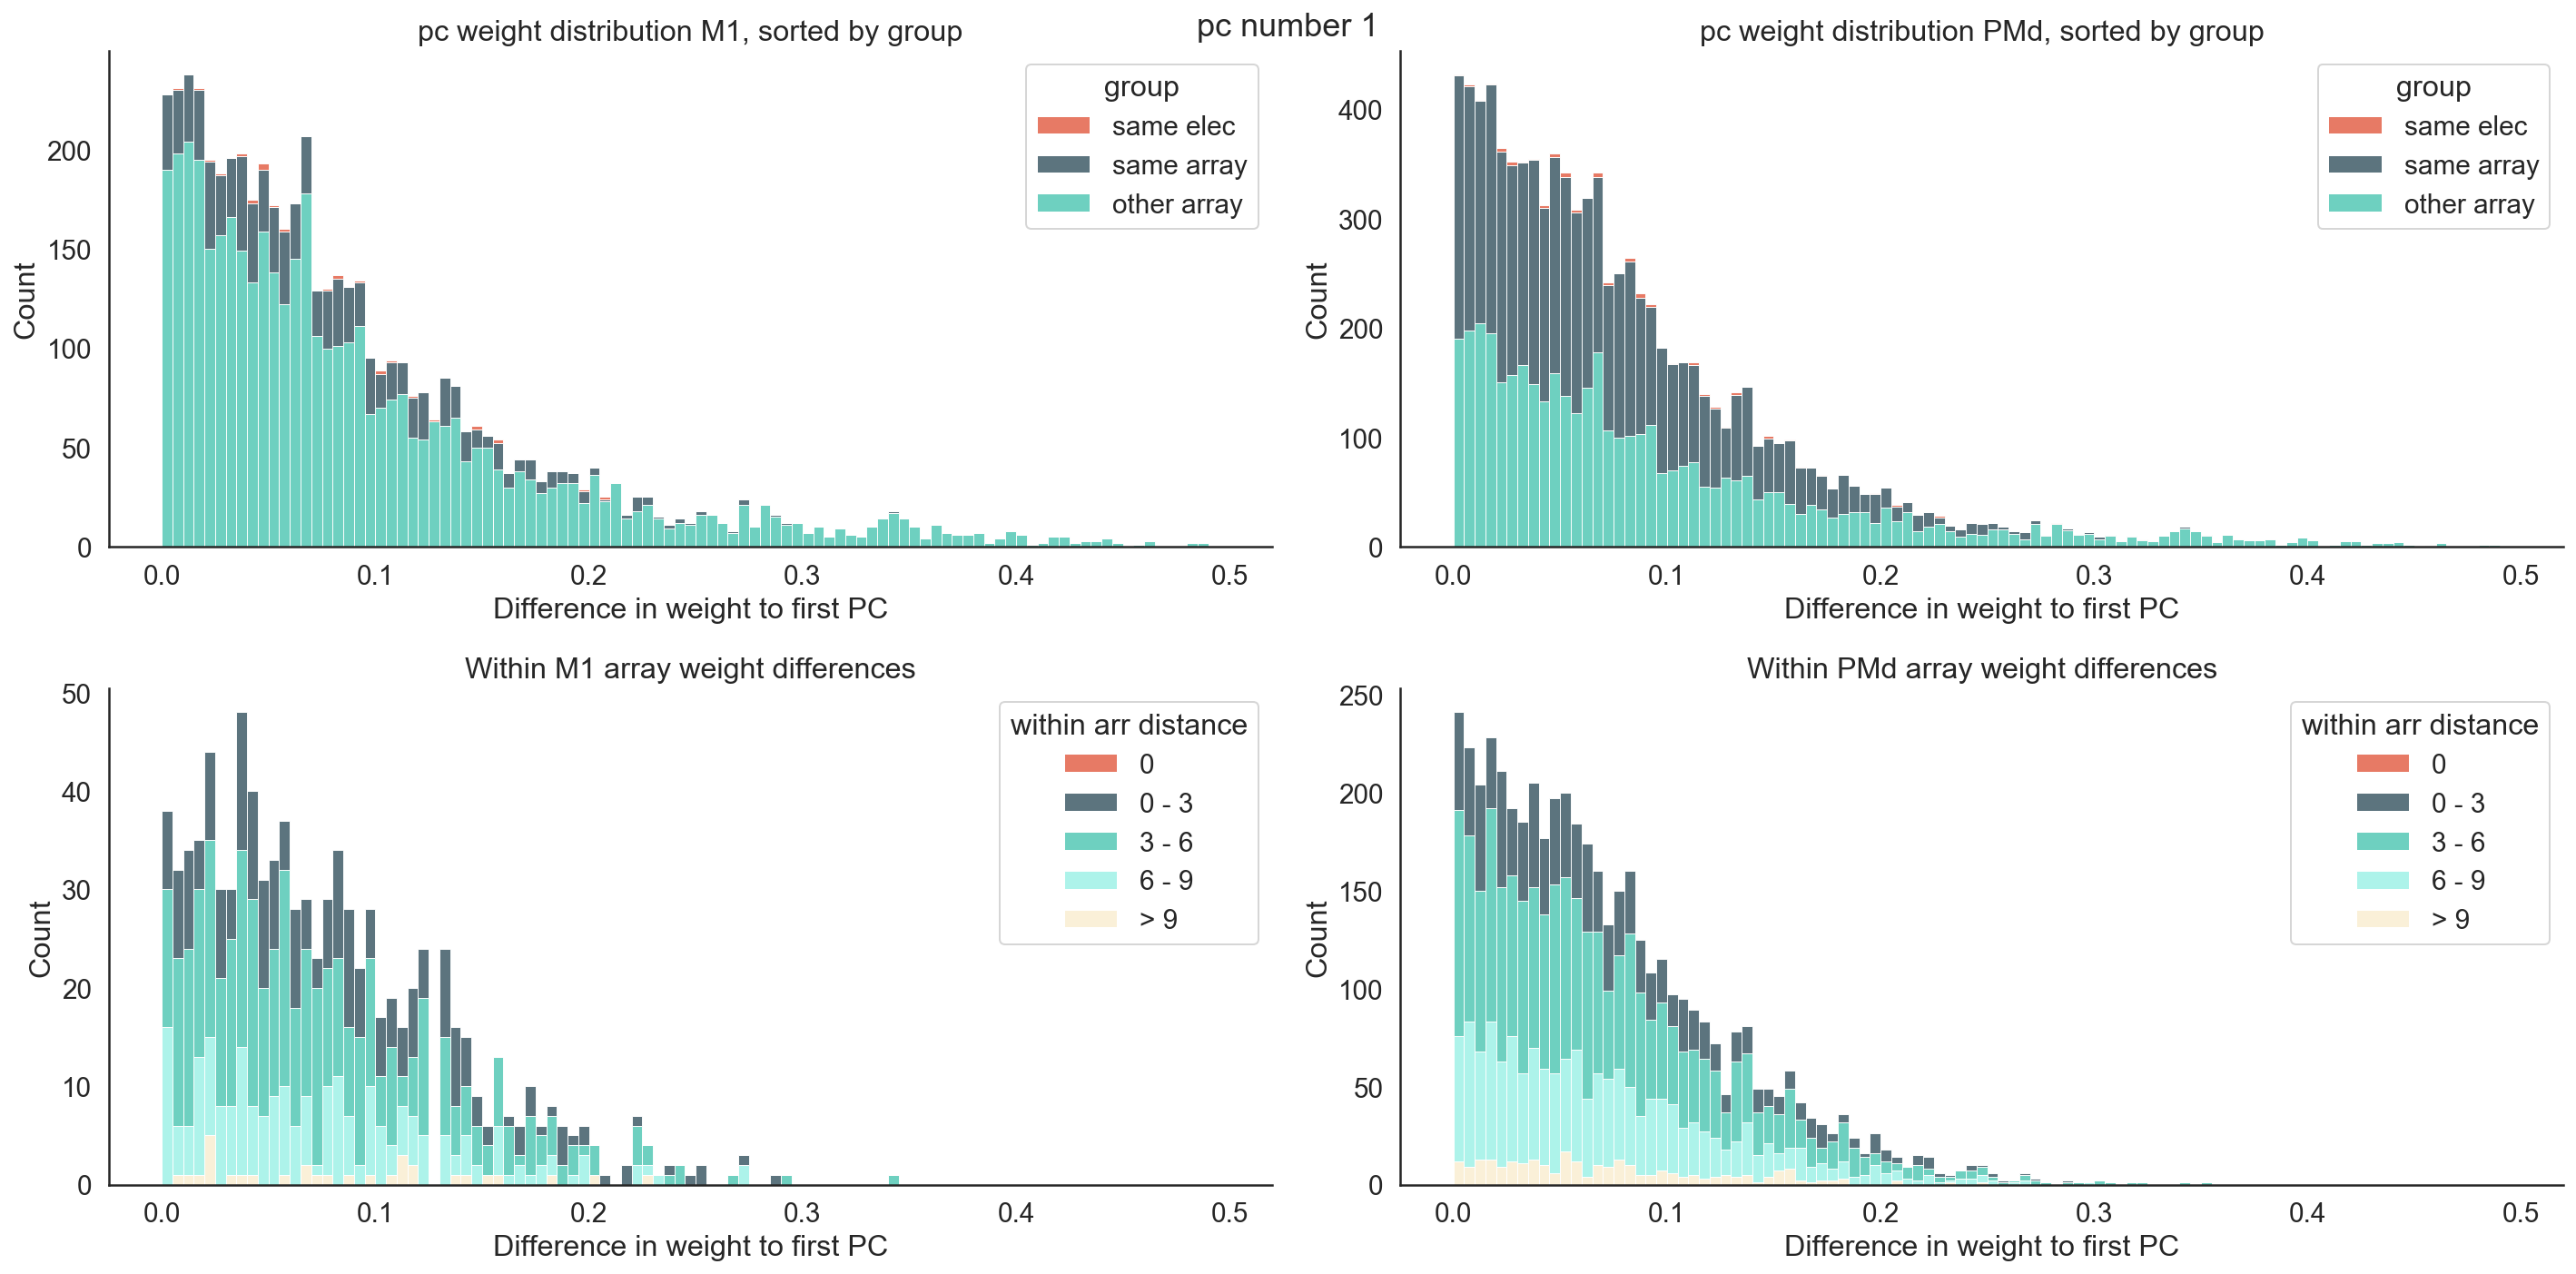

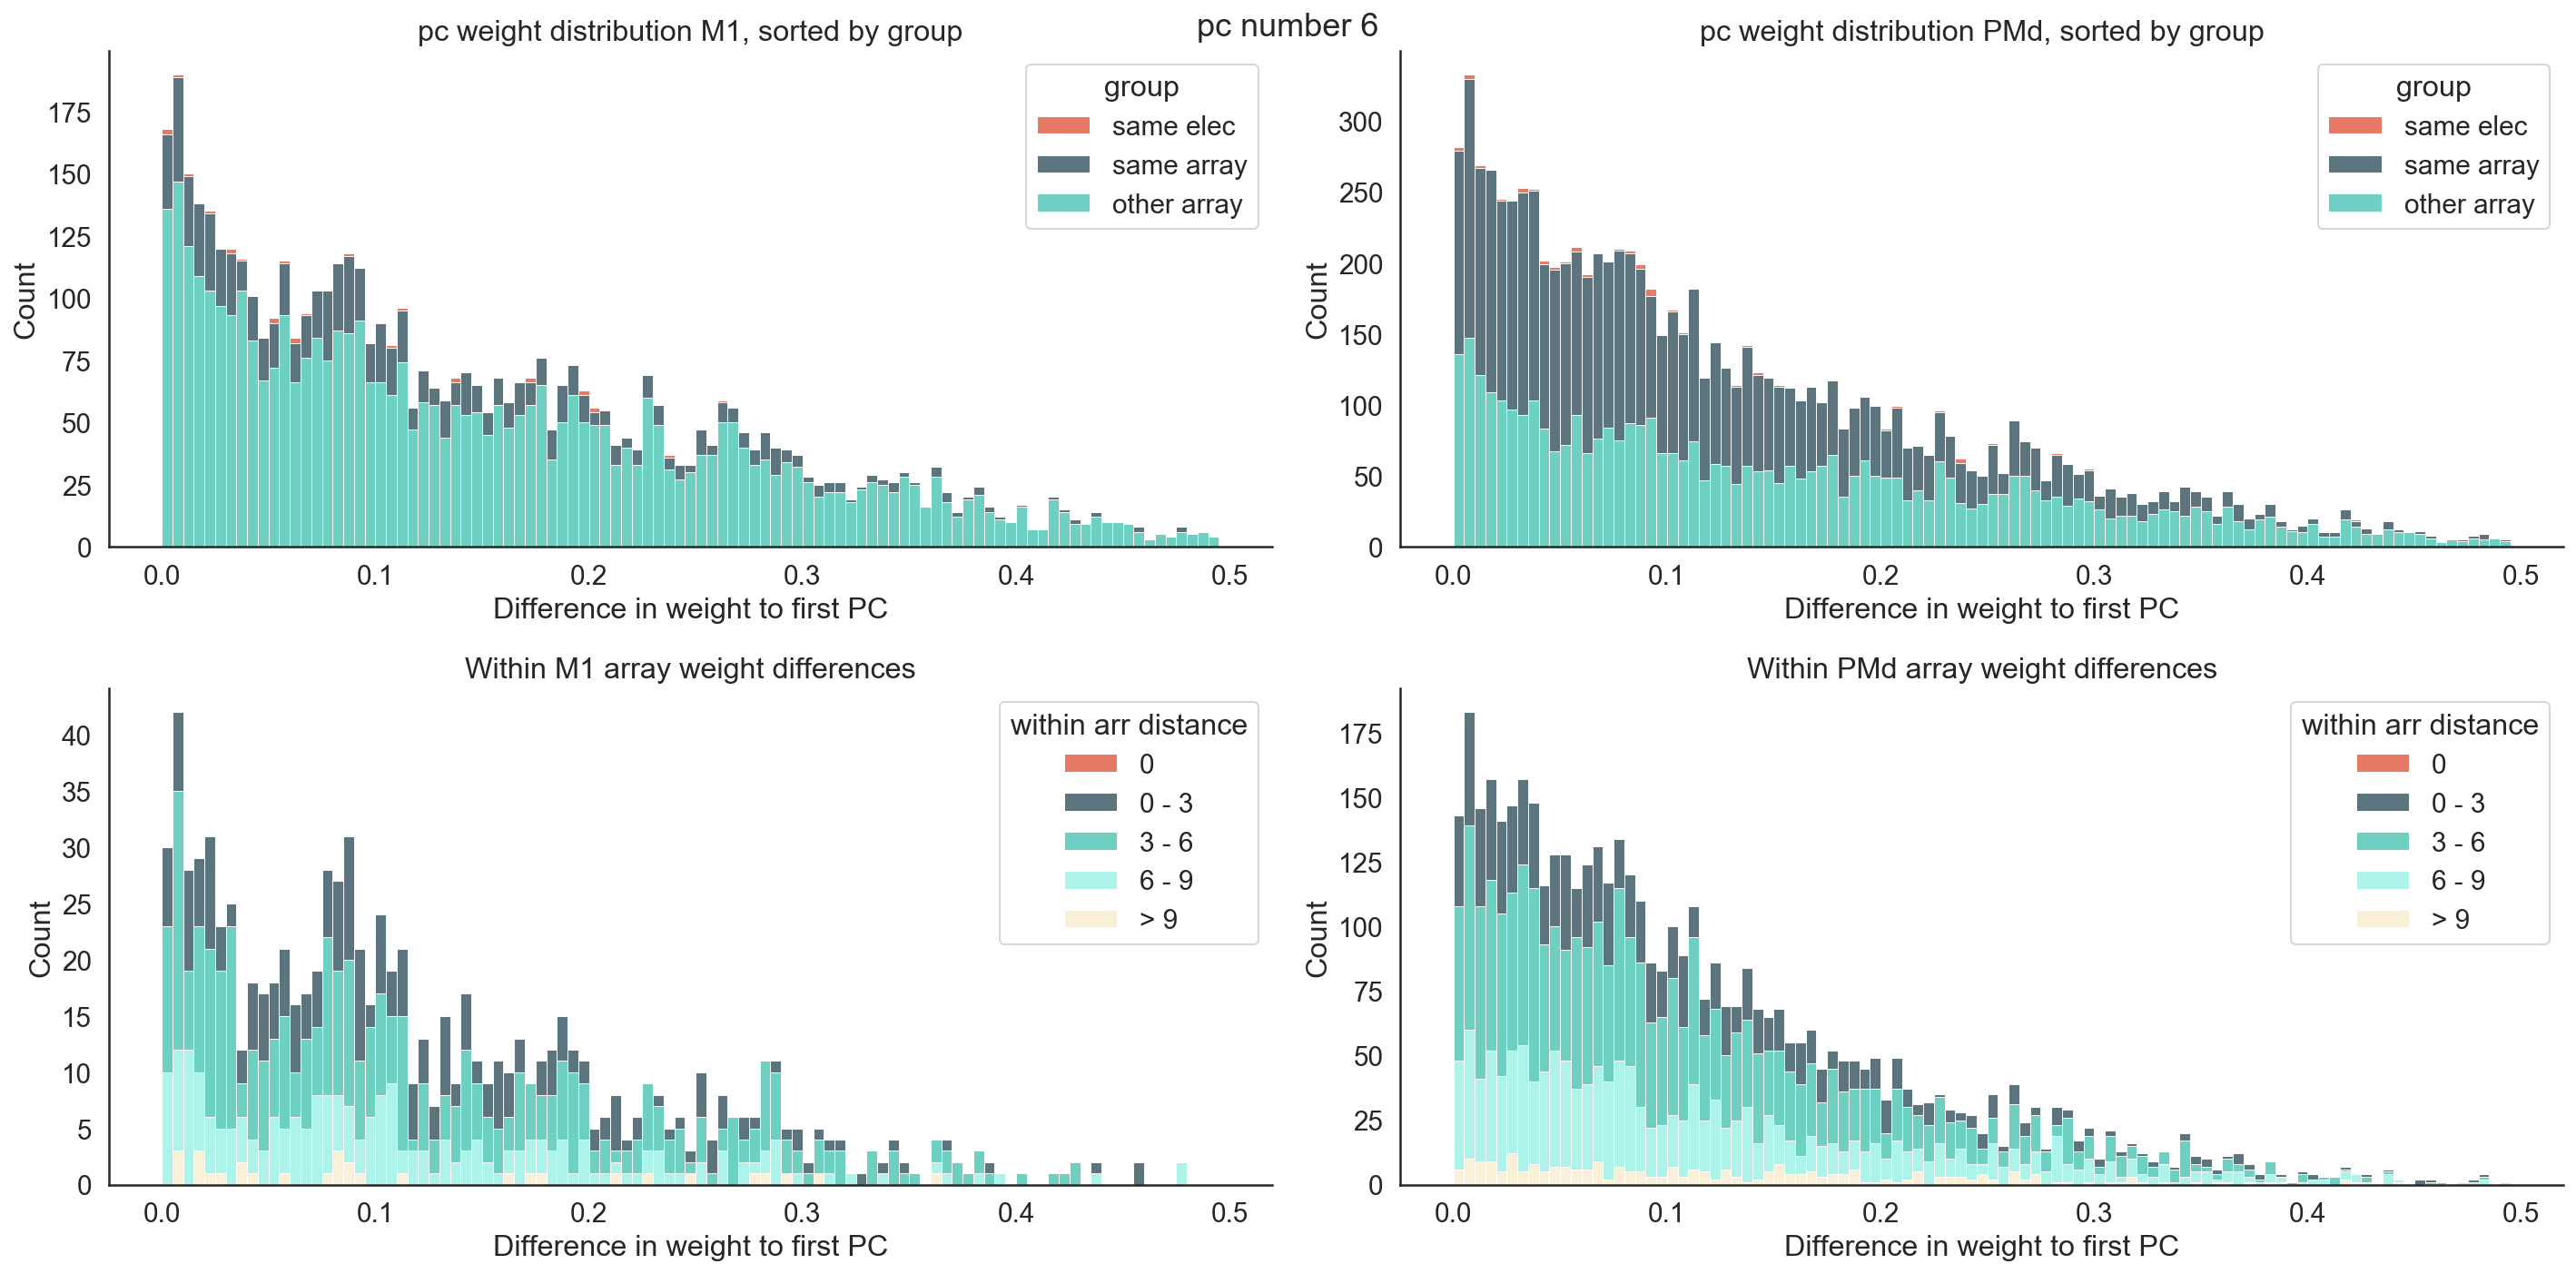

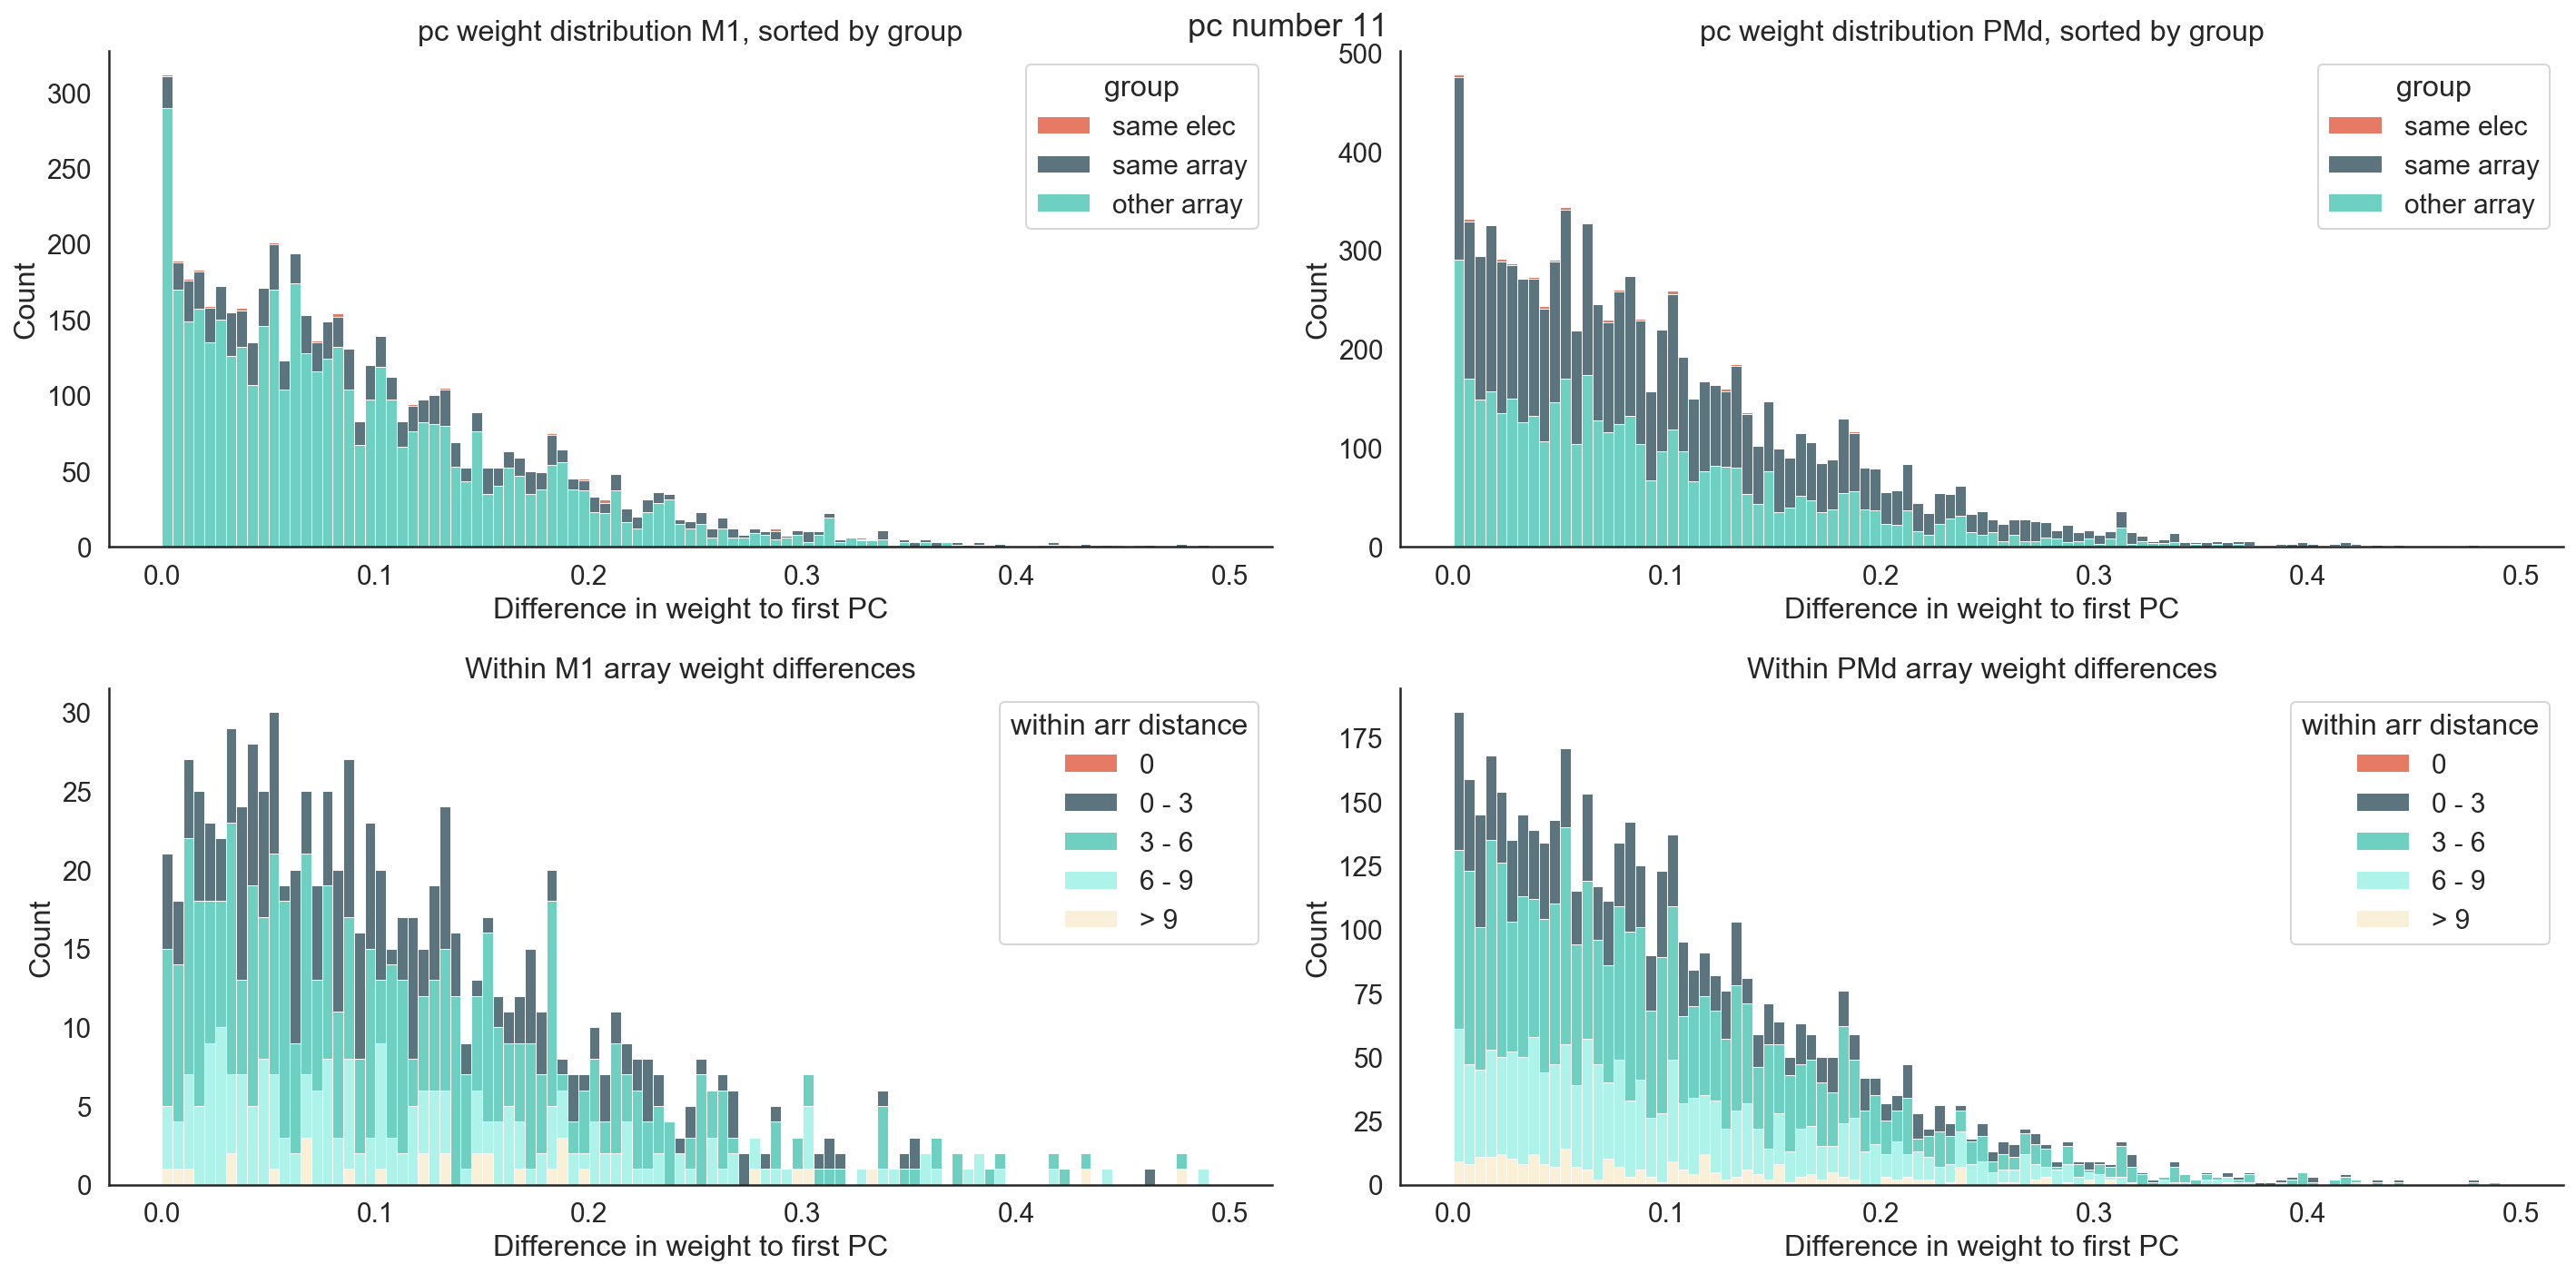

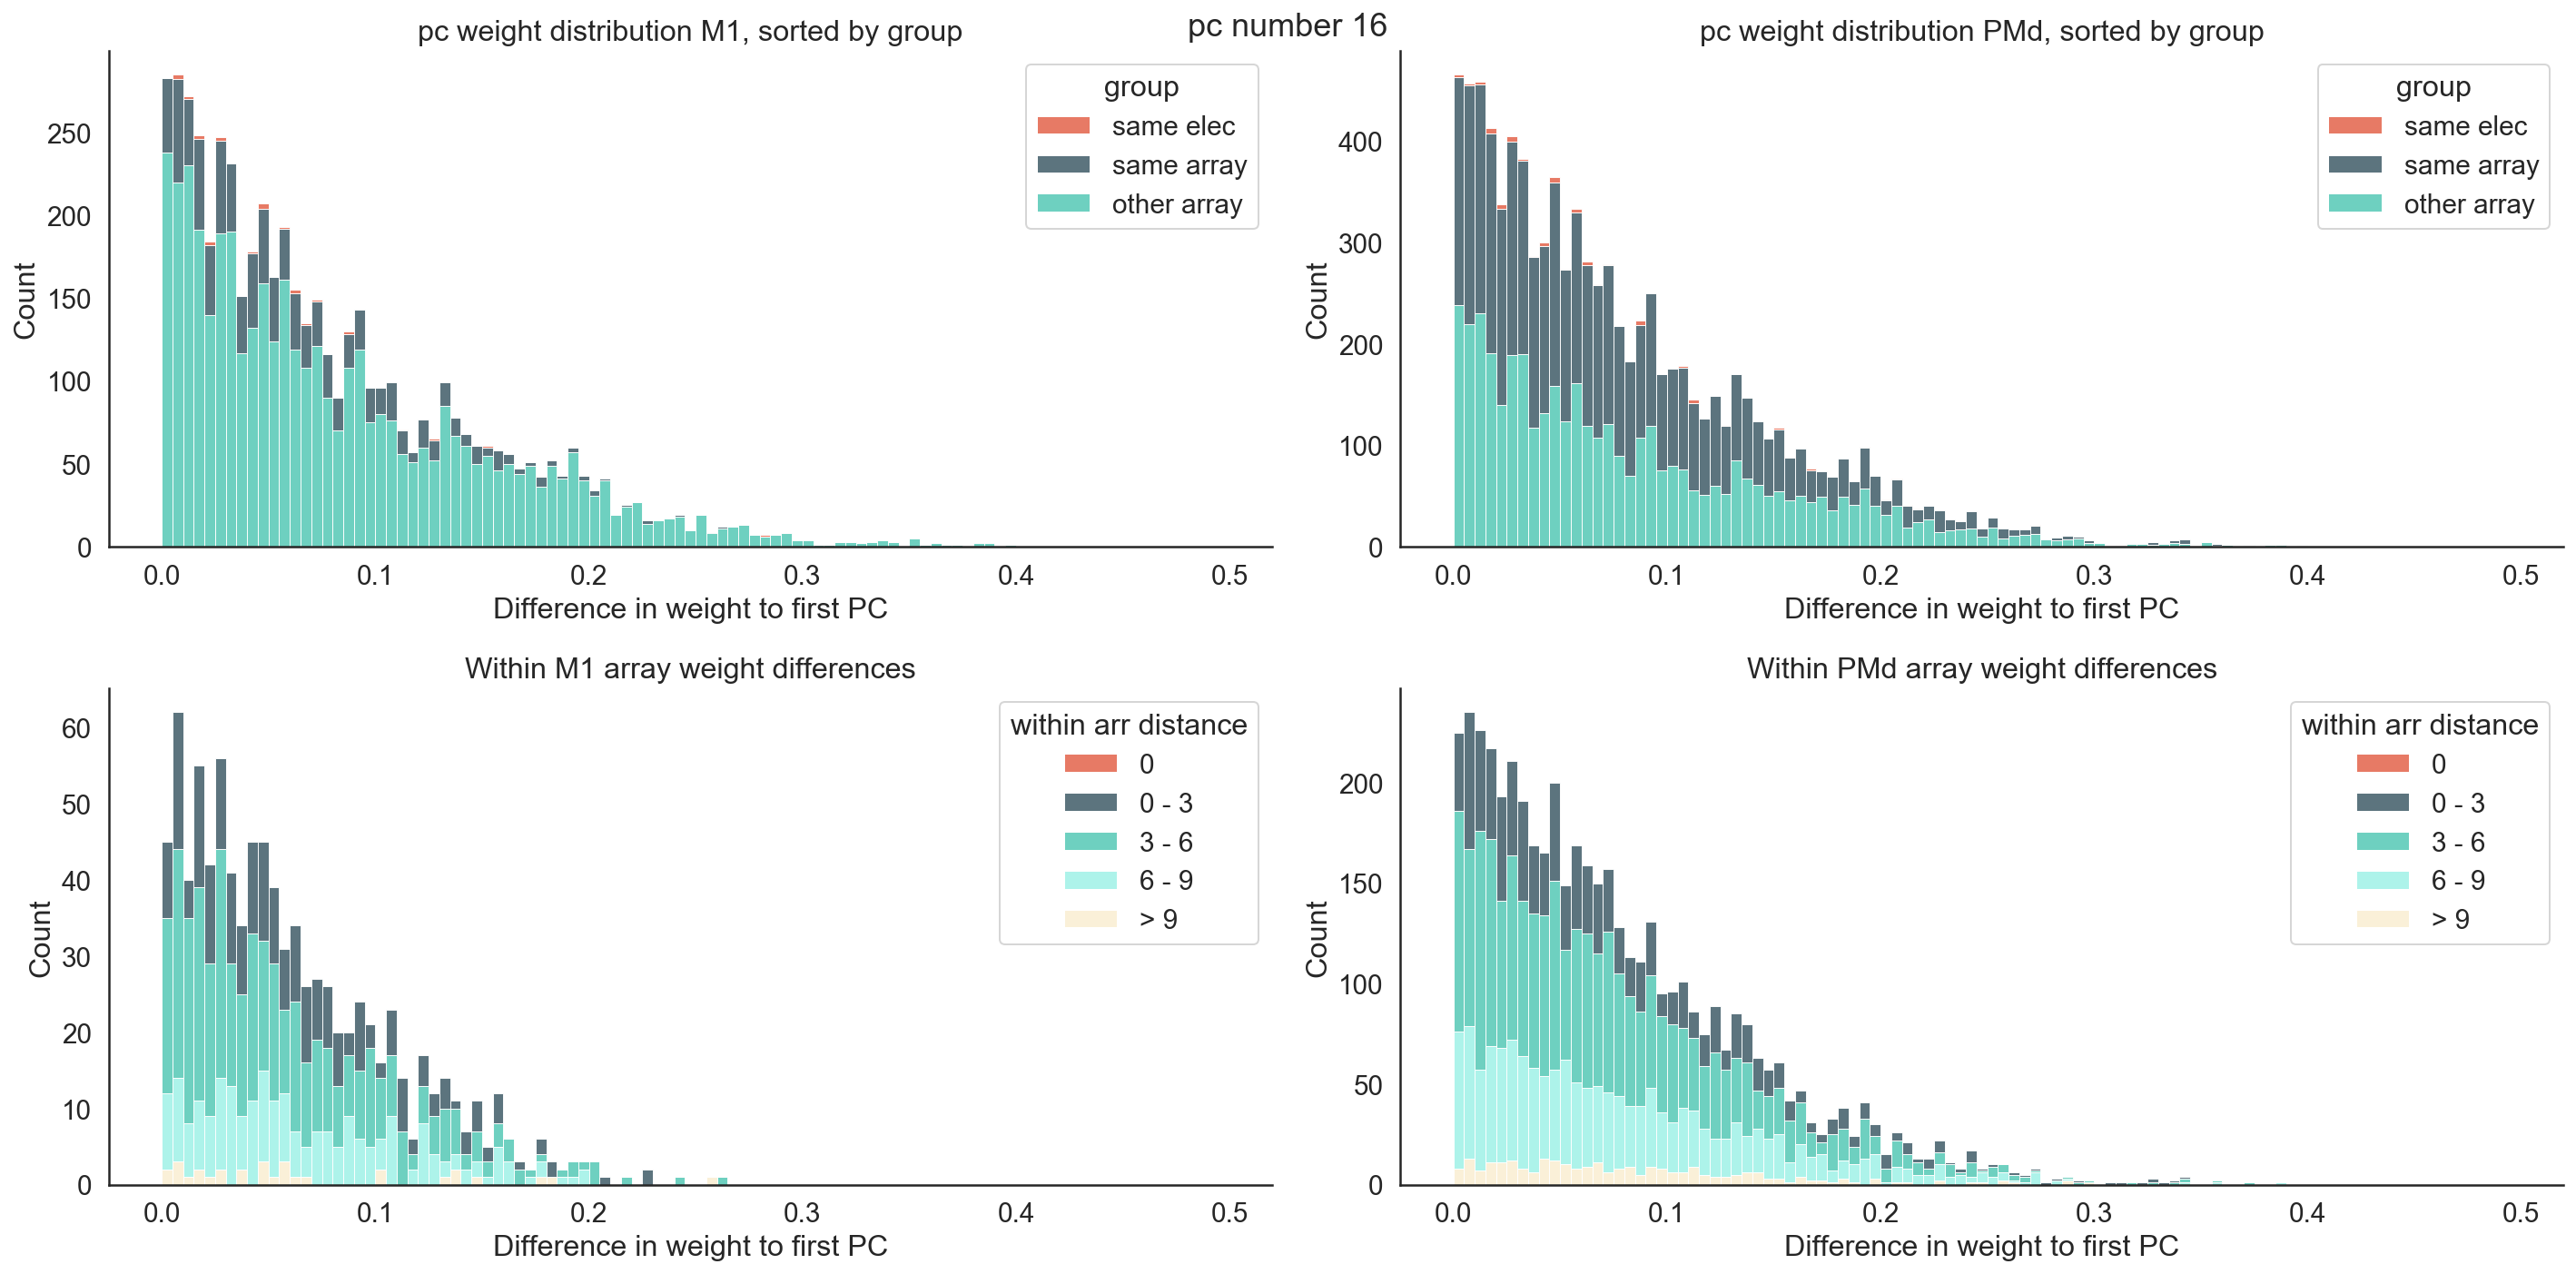

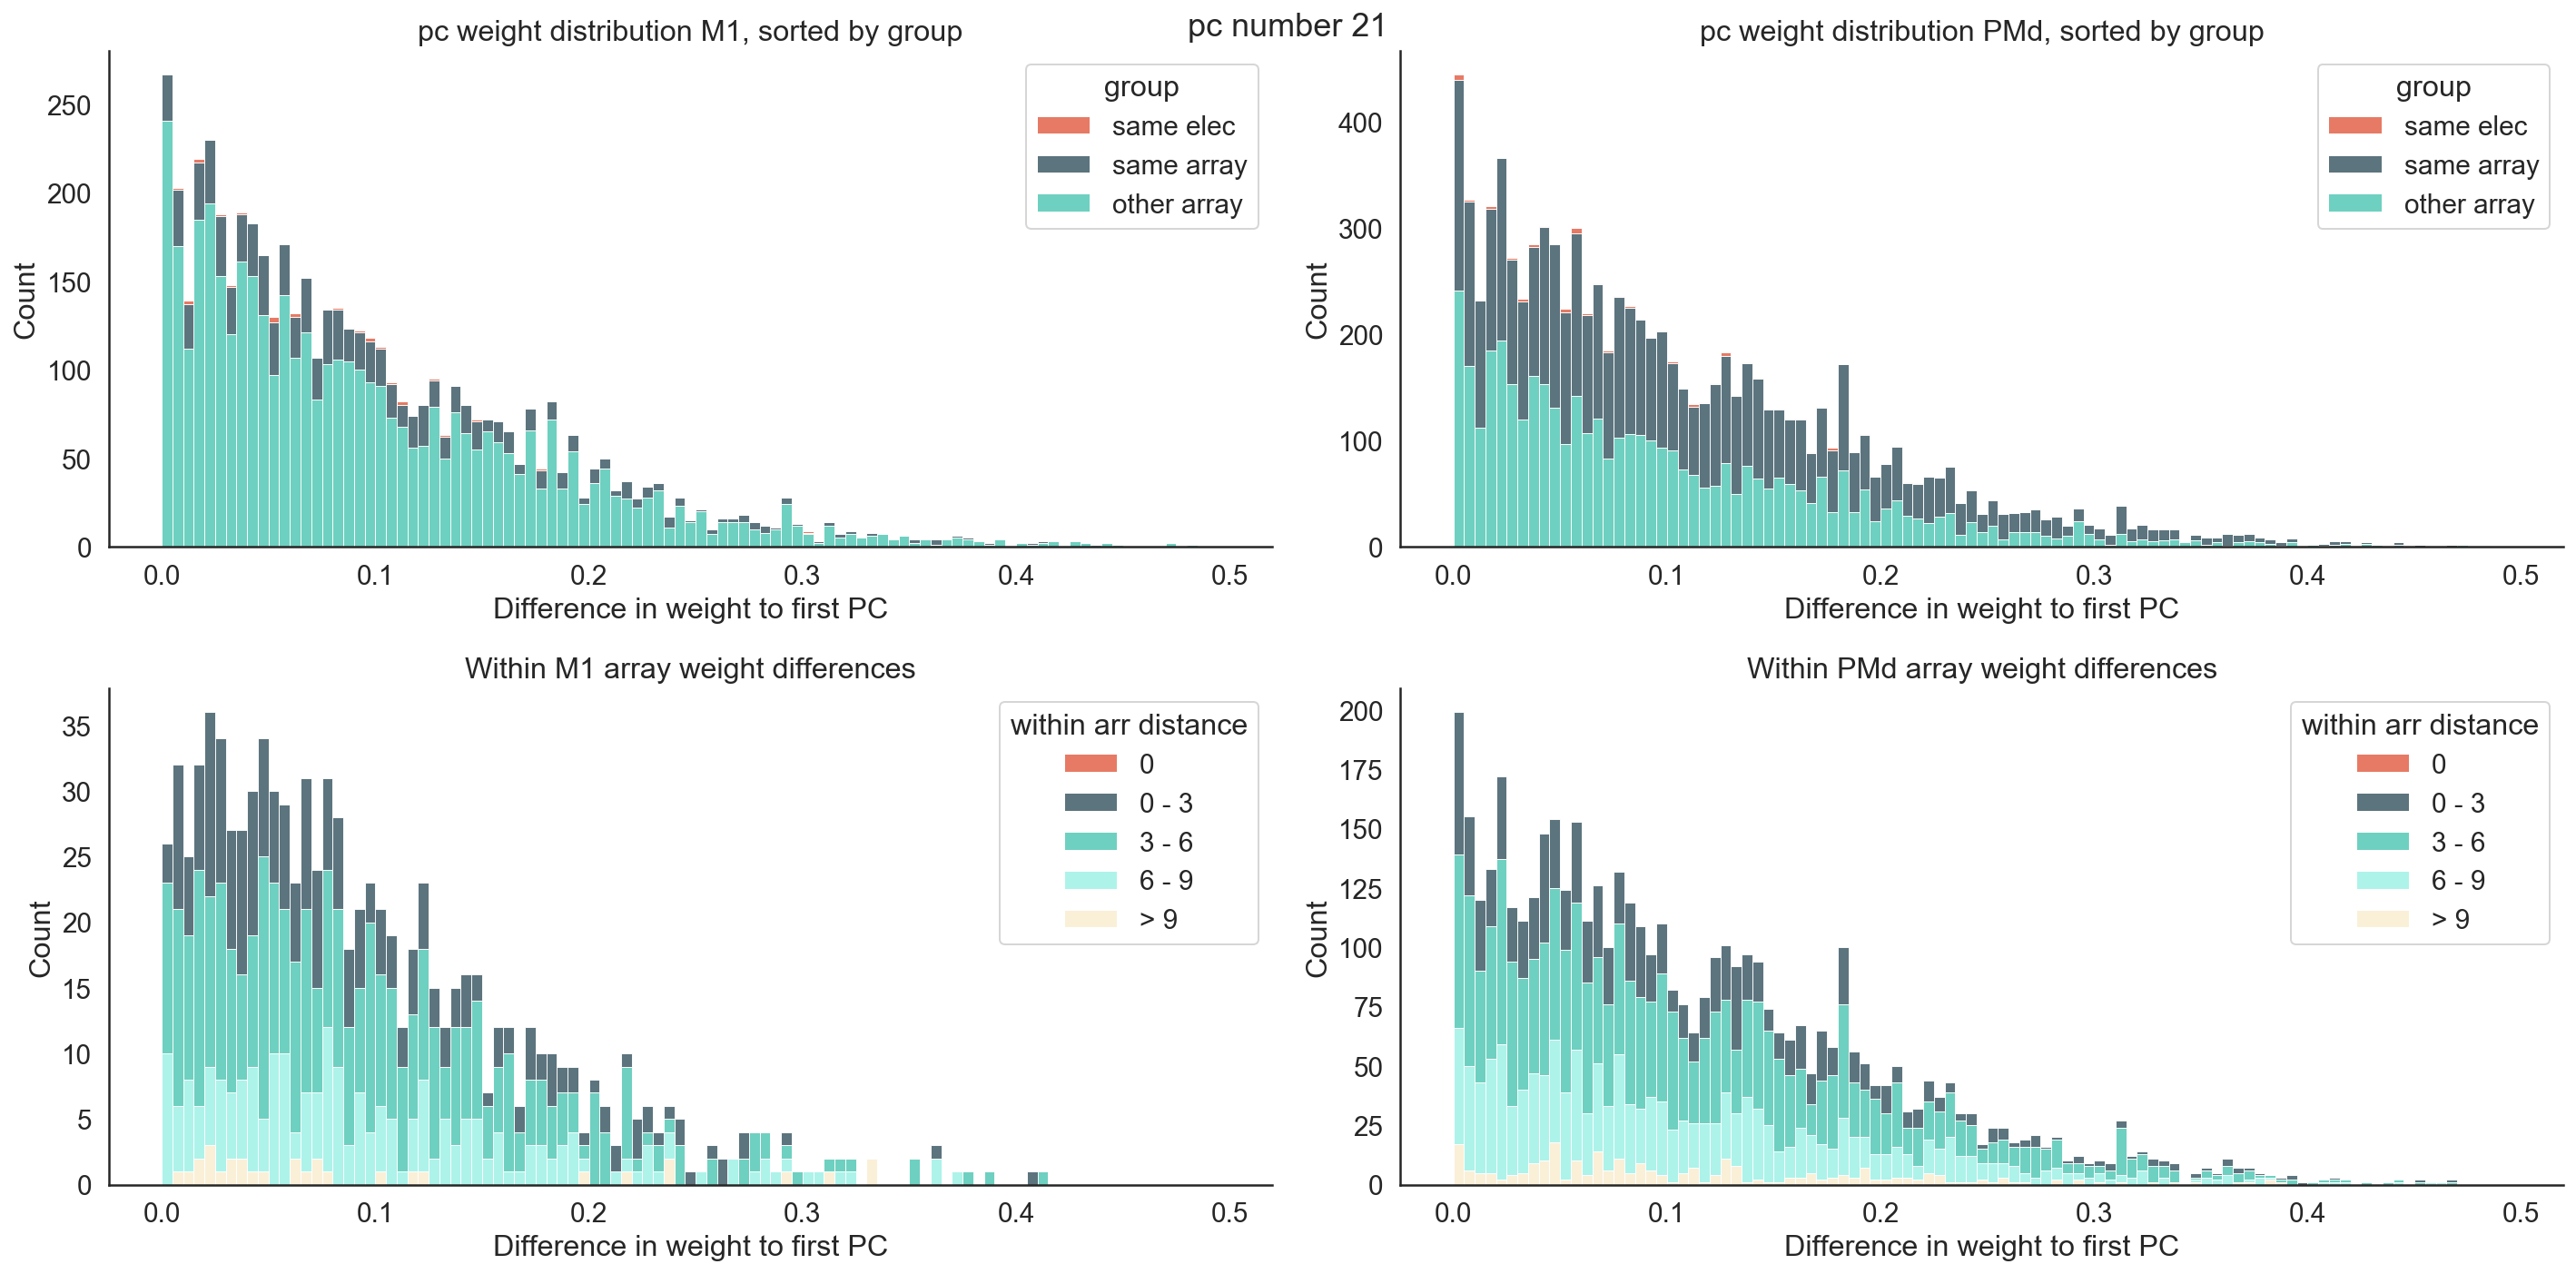

In [41]:
for i in np.arange(0, 25, 5):

    plot_weight_distrib(pc_num=i)

## Sparse PCA with different values for $\alpha$

How does the sparseness of the principal components change for different values of $\alpha$ (the penalty term)?

In [ ]:
# alpha_range = np.arange(0.1, 10, 0.5)
# sparsities  = []
# sparseness = lambda x: 1 - np.count_nonzero(x)/x.size

# for a in tqdm(alpha_range, desc='overall progress'):
    
#     X = np.concatenate(td['both_rates'].values, axis=0)
#     spca = decomposition.MiniBatchSparsePCA(n_components=X.shape[1], alpha=a, verbose=4, normalize_components=True) 
#     spca.fit(X); 

#     # get the principal components
#     spcs = spca.components_

#     # compute sparseness
#     sparsities.append(round(sparseness(spcs), 3))

In [ ]:
# fig, ax = plt.subplots(1, figsize=(8, 6))

# ax.plot(alpha_range, sparsities);
# ax.set_xlabel('value of penalty term')
# ax.set_ylabel('percentage of zero elements');

In [ ]:
# def plot_weight_distrib(pc_num):
    
#     # compare weights
#     df = compare_pc_weights(m1_arr=m1_elecmap, m1_ug=td['M1_unit_guide'][0], pmd_arr=pmd_elecmap, pmd_ug=td['PMd_unit_guide'][0], w=spcs[:, pc_num] )
#     df_m1_other  = df.loc[df['array'].isin(['M1', np.nan])]
#     df_pmd_other = df.loc[df['array'].isin(['PMd', np.nan])]
#     df_same_arr = df.loc[df['group'] == 'same array']
    
#     m1_cats = df_same_arr.loc[df['array']=='M1']
#     pmd_cats = df_same_arr.loc[df['array']=='PMd']
    
#     # make plots 2x2
#     # mostly interested in weight differcences in this way, first one is more as sanity check
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
#     fig.suptitle(f'pc number {pc_num + 1}', fontsize=18)
#     sns.histplot(df_m1_other, x='w_diff', hue='group', bins=binz, stat='count', multiple='stack', ax=ax1)
#     ax1.set_title('pc weight distribution M1, sorted by group')
#     ax1.set_xlabel('Difference in weight to first PC')

#     sns.histplot(df_pmd_other, x='w_diff', hue='group', bins=binz, stat='count', multiple='stack', ax=ax2)
#     ax2.set_title('pc weight distribution PMd, sorted by group')
#     ax2.set_xlabel('Difference in weight to first PC')

#     sns.histplot(m1_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax3, multiple='stack')
#     ax3.set_title('Within M1 array weight differences')
#     ax3.set_xlabel('Difference in weight to first PC')

#     sns.histplot(pmd_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax4, multiple='stack')
#     ax4.set_title('Within PMd array weight differences')
#     ax4.set_xlabel('Difference in weight to first PC')
#     sns.despine()
#     plt.tight_layout()